运行环境：
CPU：Intel® Xeon® E5-2680 v4 CPU，主频2.4GHz
GPU：NVIDIA® Tesla® P40（12TFLOPS 单精度浮点计算，47INT8 TOPS）
内存：DDR4，2666MT/s。
操作系统：Linux Ubuntu 18.04 LTS
CUDA 11.2

In [2]:
import os
import time
from functools import partial
from tqdm import tqdm

import numpy as np
import pandas as pd
import sklearn

import paddle
import paddlenlp
from paddlenlp.datasets import load_dataset
from rouge import Rouge
from visualdl import LogWriter

from paddlenlp.transformers import PegasusForConditionalGeneration, PegasusChineseTokenizer
from paddlenlp.transformers import LinearDecayWithWarmup
from paddle.io import BatchSampler, DataLoader
from paddlenlp.data import DataCollatorForSeq2Seq
from paddlenlp.utils.log import logger

D:\Program\Anaconda\envs\paddle\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# 1 数据读入

In [3]:
data_path = './processed/train_data_all.csv'
data=pd.read_csv(data_path,encoding='utf-8',sep='|')
data['content'].str.len().describe()

count    24992.000000
mean       419.802937
std        121.761374
min         11.000000
25%        330.000000
50%        512.000000
75%        512.000000
max        513.000000
Name: content, dtype: float64

## 1.1 构造训练集和测试集

In [67]:
df=sklearn.utils.shuffle(data) #随机打乱
train_data = df.sample(frac=0.9, random_state=0, axis=0)
dev_data = df.drop(train_data.index)
# train_data = train_data[0:100]
# dev_data = dev_data[0:3]
train_data_path = './processed/train_data.csv'
dev_data_path = './processed/dev_data.csv'
# #将训练数据写入到文件中
train_data.to_csv(train_data_path,  index=False,encoding='utf-8',sep ='|',header =['id','content','abstract'])
# #将测试数据写入文件中
dev_data.to_csv(dev_data_path,  index=False,encoding='utf-8',sep ='|',header =['id','content','abstract'])

In [68]:
print("================train===============")
print(train_data['content'].str.len().describe())
print("=================dev=================")
print(dev_data['content'].str.len().describe())
print("====================================")

================train===============
count    22493.000000
mean       419.906282
std        121.895025
min         11.000000
25%        330.000000
50%        512.000000
75%        512.000000
max        513.000000
Name: content, dtype: float64
=================dev=================
count    2499.000000
mean      418.872749
std       120.571935
min        50.000000
25%       330.000000
50%       512.000000
75%       512.000000
max       513.000000
Name: content, dtype: float64


# 2 训练

## 2.1 参数配置

In [69]:
MAX_CONTENT_LENGTH = 512
MAX_ABSTRACT_LENGTH = 160
MIN_CONTENT_LENGTH = 0
MIN_ABSTRACT_LENGTH = 0
BATCH_SIZE = 8 # 8
WARMUP_RATIO = 0.02
LR_RATE = 5e-5
EPOCHS_NUM =50 # 50
LOG_STEP = 2000 # 2000
SSTIA_RATIO = 0.5 # 0.5
USE_SSTIA = True
NUM_BEAM = 4
ROUGE_METRIC_NAME = ['rouge-1', 'rouge-2', 'rouge-l']
CHECKPOINT_DIR = 'checkpoints'
LOG_WRITER = LogWriter('visualdl_log_dir')

## 2.2 构造dataloader与加载预训练模型

In [70]:
def read_from_csv(data_path):
    data=pd.read_csv(data_path,encoding='utf-8',sep='|')
    for index, row in data.iterrows():
        content, abstract = row['content'],row['abstract']
        yield {'content': content, 'abstract': abstract}
def read_from_csv(data_path):
    with open(data_path, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            content, abstract = line.strip('\t').split("|")[1].strip(),line.strip('\t').split("|")[2].strip()
            yield {'content': content, 'abstract': abstract}
train_dataset  = load_dataset(read_from_csv, data_path=train_data_path, lazy=False, split="train")
dev_dataset  = load_dataset(read_from_csv, data_path=dev_data_path, lazy=False, split="dev")
print(len(train_dataset))
print(len(dev_dataset))

22501
2500


In [21]:
# 加载Toleknizer
tokenizer = PegasusChineseTokenizer.from_pretrained('IDEA-CCNL/Randeng-Pegasus-238M-Summary-Chinese')
# 加载预训练模型
model = PegasusForConditionalGeneration.from_pretrained('IDEA-CCNL/Randeng-Pegasus-238M-Summary-Chinese')
# 设置数据收集器
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

[2023-06-11 03:21:39,465] [    INFO] - Already cached C:\Users\cyberloafing\.paddlenlp\models\IDEA-CCNL/Randeng-Pegasus-238M-Summary-Chinese\vocab.txt
[2023-06-11 03:21:39,466] [    INFO] - Already cached C:\Users\cyberloafing\.paddlenlp\models\IDEA-CCNL/Randeng-Pegasus-238M-Summary-Chinese\added_tokens.json
[2023-06-11 03:21:39,467] [    INFO] - Already cached C:\Users\cyberloafing\.paddlenlp\models\IDEA-CCNL/Randeng-Pegasus-238M-Summary-Chinese\special_tokens_map.json
[2023-06-11 03:21:39,468] [    INFO] - Already cached C:\Users\cyberloafing\.paddlenlp\models\IDEA-CCNL/Randeng-Pegasus-238M-Summary-Chinese\tokenizer_config.json
[2023-06-11 03:21:39,515] [    INFO] - Already cached C:\Users\cyberloafing\.paddlenlp\models\IDEA-CCNL/Randeng-Pegasus-238M-Summary-Chinese\model_state.pdparams
[2023-06-11 03:21:39,516] [    INFO] - Already cached C:\Users\cyberloafing\.paddlenlp\models\IDEA-CCNL/Randeng-Pegasus-238M-Summary-Chinese\model_config.json


In [33]:
def tokenize_input(example,
                   content_name,
                   abstract_name,
                   tokenizer,
                   max_content_length,
                   max_abstract_length):
    """
    将输入的example中的content和abstract转换为id，并构造labels
    :arg example: 一个样本，包含content和abstract
    :arg content_name: content的key
    :arg abstract_name: abstract的key
    :arg tokenizer: 分词器
    :arg max_content_length: content的最大长度
    :arg max_abstract_length: abstract的最大长度
    :return: 返token后的input
    """
    inputs,targets = example[content_name],example[abstract_name]
    tokened_inputs = tokenizer(inputs,
                             max_length=max_content_length,
                             padding=False,
                             truncation=True,
                             return_attention_mask=True)
    tokened_labels = tokenizer(targets,
                       max_length=max_abstract_length,
                       padding=False,
                       truncation=True)
    # 把token后的【label】换为【input_ids】
    tokened_inputs["labels"] = tokened_labels["input_ids"]
    return tokened_inputs
packed_tokened_fn = partial(tokenize_input,
                            content_name='content',
                            abstract_name='abstract',
                            tokenizer=tokenizer,
                            max_content_length=MAX_CONTENT_LENGTH,
                            max_abstract_length=MAX_ABSTRACT_LENGTH)
# train_dataset和dev_dataset分别转换
train_dataset = train_dataset.map(packed_tokened_fn,batched=False,lazy =False)
dev_dataset = dev_dataset.map(packed_tokened_fn,batched=False,lazy =False)

In [34]:
print(train_dataset[0])

{'input_ids': [1117, 131, 15214, 1909, 2274, 11447, 28537, 3399, 4054, 13048, 30521, 5661, 1266, 43766, 1909, 827, 6948, 3399, 30521, 1117, 131, 1266, 5219, 2251, 5230, 200, 30521, 1477, 200, 18820, 2335, 33335, 541, 28527, 10144, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [25416, 21704, 3624, 28967, 2335, 7257, 28537, 12695, 5661, 32425, 18739, 1735, 430, 8214, 8220, 266, 5661, 5034, 8177, 28967, 115, 115, 115, 115, 115, 115, 115, 115, 12695, 266, 5661, 6250, 8214, 35160, 119, 25416, 30255, 32248, 28967, 35108, 501, 3399, 30698, 5661, 4659, 12942, 11712, 14290, 5661, 30952, 179, 1]}


In [35]:
train_data_loader  = paddle.io.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,return_list=True,collate_fn=data_collator)
dev_batch_sampler  = BatchSampler(dataset=dev_dataset,batch_size=BATCH_SIZE,shuffle=False)
dev_data_loader = DataLoader(dataset=dev_dataset,batch_sampler=dev_batch_sampler,collate_fn=data_collator,return_list=True)

## 2.3 PEGASUS类

In [55]:
class PEGASUS():
    def __init__(self, model, tokenizer,train_data_loader,dev_data_loader):
        self.model = model
        self.tokenizer = tokenizer
        self.lr_rate = LR_RATE
        self.checkpoint_dir = CHECKPOINT_DIR
        self.global_step = 0
        self.best_rouge = 0
        self.eval_steps = 20000
        self.lr_scheduler = LinearDecayWithWarmup(self.lr_rate, self.eval_steps, 0.1)
        self.decay_params = [
            p.name for n, p in self.model.named_parameters()
            if not any(nd in n for nd in ["bias", "norm"])
        ]
        self.optimizer = paddle.optimizer.AdamW(
            learning_rate=self.lr_scheduler,
            beta1=0.9,
            beta2=0.999,
            epsilon=1e-6,
            parameters=self.model.parameters(),
            weight_decay=0.01,
            apply_decay_param_fun=lambda x: x in self.decay_params)
        self.train_data_loader = train_data_loader
        self.dev_data_loader = dev_data_loader
        self.num_steps = len(self.train_data_loader) * EPOCHS_NUM
        self.model.use_SSTIA = USE_SSTIA
        self.model.mix_ratio = SSTIA_RATIO
        self.train_time = time.time()
        self.eval_time = time.time()
        self.mode = 'train_and_eval'

    def train_and_eval(self):
        if self.mode != 'train_and_eval':
            self.mode = 'train_and_eval'
        logger.info("***** Running training *****")
        logger.info(f"  Num examples = {len(self.train_data_loader.dataset)}")
        logger.info(f"  Num Epochs = {EPOCHS_NUM}")
        logger.info(f"  Instantaneous batch size per GPU = {BATCH_SIZE}")
        logger.info(f"  Total num training steps = {self.num_steps}")
        for epoch in range(EPOCHS_NUM):
            for step, batch in enumerate(self.train_data_loader):
                self.global_step += 1
                lm_logits, _, loss = self.model(**batch)
                loss.backward()
                self.optimizer.step()
                self.lr_scheduler.step()
                self.optimizer.clear_grad()
                if self.global_step % LOG_STEP == 0:
                    logger.info(f"【step {self.global_step}, "
                                f"epoch: {epoch}, "
                                f"batch: {step}, "
                                f"loss: {round(float(loss),5)}, "
                                f"lr: {self.optimizer.get_lr()}, "
                                f"speed: {round(LOG_STEP / (time.time() - self.train_time),4)}step/s】")
                    LOG_WRITER.add_scalar("train_loss", loss.numpy(), self.global_step)
                    self.train_time = time.time()
                # 为了节约时间，间隔一定时间进行验证
                if self.global_step % self.eval_steps == 5 or \
                        self.global_step == self.num_steps or \
                        self.global_step in [1000,6000,10000]:
                    self.eval()
        logger.info("***** Finish training *****")
    @paddle.no_grad()
    def eval(self):
        self.model.eval() # 评估模式
        all_preds = []
        all_labels = []
        self.model = self.model._layers if isinstance(self.model, paddle.DataParallel) else self.model
        for batch in tqdm(self.dev_data_loader, total=len(self.dev_data_loader), desc="Evaluation:"):
            labels = batch.pop('labels').numpy()
            preds = self.model.generate(input_ids=batch['input_ids'],
                                   attention_mask=batch['attention_mask'],
                                   min_length=MIN_ABSTRACT_LENGTH,
                                   max_length=MAX_ABSTRACT_LENGTH,
                                   # 验证时采用贪婪搜索，可以节约一些搜索时间
                                   decode_strategy='greedy_search',
                                   use_cache=True)[0]
            # tokenizer还原文本
            all_preds.extend(
                tokenizer.batch_decode(preds.numpy(),
                                       skip_special_tokens=True,
                                       clean_up_tokenization_spaces=False
                                       )
            )
            # 将-100替换为pad_token_id
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            all_labels.extend(
                tokenizer.batch_decode(labels,
                                       skip_special_tokens=True,
                                       clean_up_tokenization_spaces=False)
            )
        rouge1, rouge2, rougel= self.rouge_metrics(all_preds, all_labels)
        logger.info("eval done total : %s s" % (time.time() - self.eval_time))
        logger.info(f"Eval use time: {time.time() - self.eval_time} s")
        LOG_WRITER.add_scalar("eval_rouge1", rouge1, self.global_step)
        LOG_WRITER.add_scalar("eval_rouge2", rouge2, self.global_step)
        LOG_WRITER.add_scalar("eval_rougel", rougel, self.global_step)
        # 根据公式计算rouge_score
        rouge_score = rouge1 * 0.2 + rouge2 * 0.4 + rougel * 0.4
        LOG_WRITER.add_scalar("eval_rouge_score", rouge_score, self.global_step)
        # 保存最优模型
        if self.best_rouge < rouge_score:
            self.best_rouge = rouge_score
            if paddle.distributed.get_rank() == 0:
                if not os.path.exists(self.checkpoint_dir):
                    os.makedirs(self.checkpoint_dir)
                model_to_save = self.model._layers if isinstance(self.model, paddle.DataParallel) else self.model
                model_to_save.save_pretrained(self.checkpoint_dir)
                self.tokenizer.save_pretrained(self.checkpoint_dir)
        self.model.train() # 恢复训练模式

    def rouge_metrics(self,preds, labels):
        rouge = Rouge()
        scores = []
        for pred, target in zip(preds, labels):
            try:
                score = rouge.get_scores(' '.join(pred), ' '.join(target))
                for name in ROUGE_METRIC_NAME:
                    scores.append(score[0][name]['f'])
            except ValueError:
                scores.append([0, 0, 0])
        rouge1 = np.mean([i for i in scores])
        rouge2 = np.mean([i for i in scores])
        rougel = np.mean([i for i in scores])
        print(f"rouge-1: {rouge1}, rouge-2: {rouge2}, rouge-l: {rougel}")
        return rouge1, rouge2, rougel

In [56]:
PEGASUS_=PEGASUS(model=model,
        tokenizer=tokenizer,
        train_data_loader=train_data_loader,
        dev_data_loader=dev_data_loader)

In [42]:
# 输出仅为测试时使用，实际运行参数并非如此
PEGASUS.train_and_eval()

[2023-06-11 03:27:17,985] [    INFO] - ***** Running training *****
[2023-06-11 03:27:17,986] [    INFO] -   Num examples = 100
[2023-06-11 03:27:17,987] [    INFO] -   Num Epochs = 1
[2023-06-11 03:27:17,988] [    INFO] -   Instantaneous batch size per GPU = 1
[2023-06-11 03:27:17,989] [    INFO] -   Total num training steps = 100
[2023-06-11 03:27:18,706] [    INFO] - 【step 1, epoch: 0, batch: 0, loss: 2.64153, lr: 2.5000000000000002e-08, speed: 0.8683step/s】
[2023-06-11 03:27:19,441] [    INFO] - 【step 2, epoch: 0, batch: 1, loss: 2.45194, lr: 5.0000000000000004e-08, speed: 1.362step/s】
[2023-06-11 03:27:19,694] [    INFO] - 【step 3, epoch: 0, batch: 2, loss: 2.3776, lr: 7.500000000000001e-08, speed: 3.9643step/s】
[2023-06-11 03:27:19,913] [    INFO] - 【step 4, epoch: 0, batch: 3, loss: 1.97816, lr: 1.0000000000000001e-07, speed: 4.5937step/s】
[2023-06-11 03:27:20,076] [    INFO] - 【step 5, epoch: 0, batch: 4, loss: 0.08576, lr: 1.2500000000000002e-07, speed: 6.1534step/s】
Evaluatio

rouge-1: 0.5018591494897813, rouge-2: 0.5018591494897813, rouge-l: 0.5018591494897813


[2023-06-11 03:27:30,759] [    INFO] - tokenizer config file saved in checkpoints\tokenizer_config.json
[2023-06-11 03:27:30,760] [    INFO] - Special tokens file saved in checkpoints\special_tokens_map.json
[2023-06-11 03:27:31,268] [    INFO] - 【step 6, epoch: 0, batch: 5, loss: 1.9518, lr: 1.5000000000000002e-07, speed: 0.0894step/s】
[2023-06-11 03:27:31,436] [    INFO] - 【step 7, epoch: 0, batch: 6, loss: 3.08358, lr: 1.7500000000000002e-07, speed: 6.0051step/s】
[2023-06-11 03:27:31,608] [    INFO] - 【step 8, epoch: 0, batch: 7, loss: 0.16612, lr: 2.0000000000000002e-07, speed: 5.8646step/s】
[2023-06-11 03:27:31,780] [    INFO] - 【step 9, epoch: 0, batch: 8, loss: 0.19492, lr: 2.25e-07, speed: 5.8302step/s】
[2023-06-11 03:27:32,007] [    INFO] - 【step 10, epoch: 0, batch: 9, loss: 3.5565, lr: 2.5000000000000004e-07, speed: 4.4336step/s】
Evaluation:: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.44s/it]
[2023-06-11 03:27:39,354] [

rouge-1: 0.5018591494897813, rouge-2: 0.5018591494897813, rouge-l: 0.5018591494897813


[2023-06-11 03:27:39,608] [    INFO] - 【step 11, epoch: 0, batch: 10, loss: 2.56964, lr: 2.75e-07, speed: 0.1316step/s】
[2023-06-11 03:27:39,824] [    INFO] - 【step 12, epoch: 0, batch: 11, loss: 2.67115, lr: 3.0000000000000004e-07, speed: 4.6503step/s】
[2023-06-11 03:27:40,062] [    INFO] - 【step 13, epoch: 0, batch: 12, loss: 0.35304, lr: 3.25e-07, speed: 4.2457step/s】
[2023-06-11 03:27:40,293] [    INFO] - 【step 14, epoch: 0, batch: 13, loss: 1.41838, lr: 3.5000000000000004e-07, speed: 4.3649step/s】
[2023-06-11 03:27:40,520] [    INFO] - 【step 15, epoch: 0, batch: 14, loss: 0.17508, lr: 3.75e-07, speed: 4.4234step/s】
[2023-06-11 03:27:40,735] [    INFO] - 【step 16, epoch: 0, batch: 15, loss: 1.75358, lr: 4.0000000000000003e-07, speed: 4.6942step/s】
[2023-06-11 03:27:40,992] [    INFO] - 【step 17, epoch: 0, batch: 16, loss: 3.46541, lr: 4.2500000000000006e-07, speed: 3.913step/s】
[2023-06-11 03:27:41,193] [    INFO] - 【step 18, epoch: 0, batch: 17, loss: 2.27919, lr: 4.5e-07, speed: 

rouge-1: 0.3689381825830514, rouge-2: 0.3689381825830514, rouge-l: 0.3689381825830514


# 3 测试
见python文件，GenerateResult.py

In [71]:
!tar -cvf checkpoints64.tar checkpoints/

tar: : Couldn't visit directory: No such file or directory
tar: Error exit delayed from previous errors.


In [51]:
!rm -rf checkpoints/

# 可视化

Text(0, 0.5, 'loss')

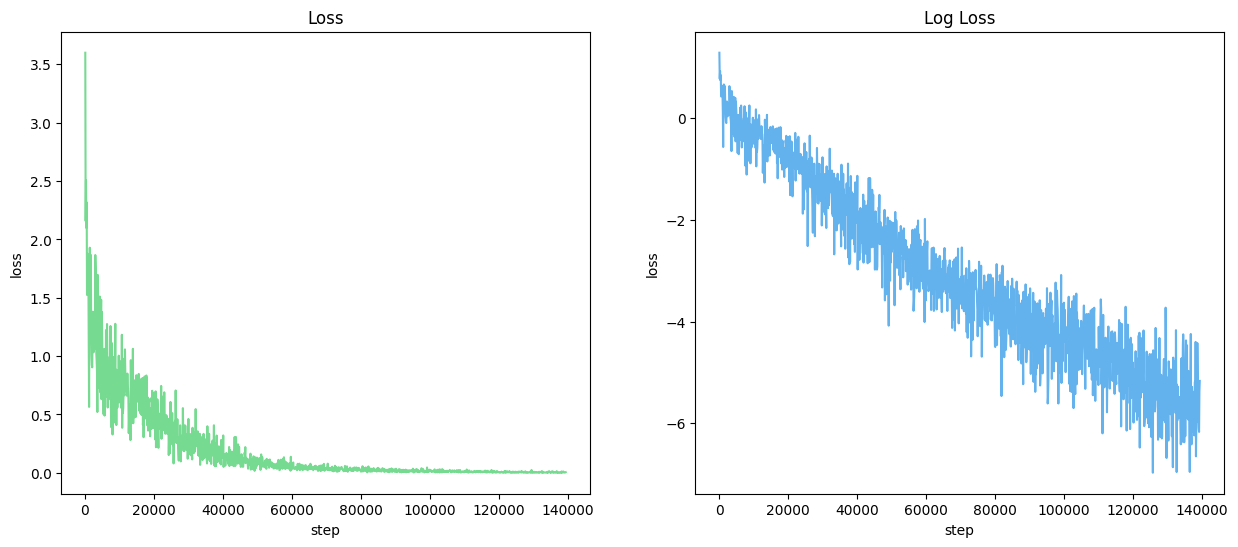

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
loss = pd.read_csv('./result/loss.csv')
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(loss['id'], loss['value'], label='train_loss',color = '#76da91')
plt.title('Loss')
plt.xlabel('step')
plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(loss['id'], np.log(loss['value']), label='train_loss',color = '#63b2ee')
plt.title('Log Loss')
plt.xlabel('step')
plt.ylabel('loss')

In [3]:
loss

,id,tag,timestamp,value
0,100,train_loss,1685975320362,3.599521
1,200,train_loss,1685975433194,2.158661
2,300,train_loss,1685975546327,2.505717
3,400,train_loss,1685975658031,2.098660
4,500,train_loss,1685975764630,2.317709
...,...,...,...,...
1389,139000,train_loss,1686129289762,0.003348
1390,139100,train_loss,1686129398855,0.002269
1391,139200,train_loss,1686129509060,0.002093
1392,139300,train_loss,1686129622018,0.004653
